In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import layers
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report



In [2]:
# Step 1: Generate Synthetic Data
def generate_data(n_samples=1000, anomaly_fraction=0.05):
    np.random.seed(42)
    normal_data = np.random.normal(loc=100, scale=20, size=(n_samples, 3))
    
    n_anomalies = int(n_samples * anomaly_fraction)
    anomalies = np.random.uniform(low=50, high=200, size=(n_anomalies, 3))
    
    data = np.vstack((normal_data, anomalies))
    labels = np.hstack((np.zeros(n_samples), np.ones(n_anomalies)))
    
    df = pd.DataFrame(data, columns=["Feature_1", "Feature_2", "Feature_3"])
    df["Anomaly_Label"] = labels  # 0: Normal, 1: Anomaly
    return df

In [3]:
# Generate the dataset
data_df = generate_data()

In [7]:
# Step 2: Data Exploration and Visualization
# Display first few rows of the dataset
print("First 5 rows of the dataset:")
print(data_df.head())

First 5 rows of the dataset:
    Feature_1   Feature_2   Feature_3  Anomaly_Label
0  109.934283   97.234714  112.953771            0.0
1  130.460597   95.316933   95.317261            0.0
2  131.584256  115.348695   90.610512            0.0
3  110.851201   90.731646   90.685405            0.0
4  104.839245   61.734395   65.501643            0.0


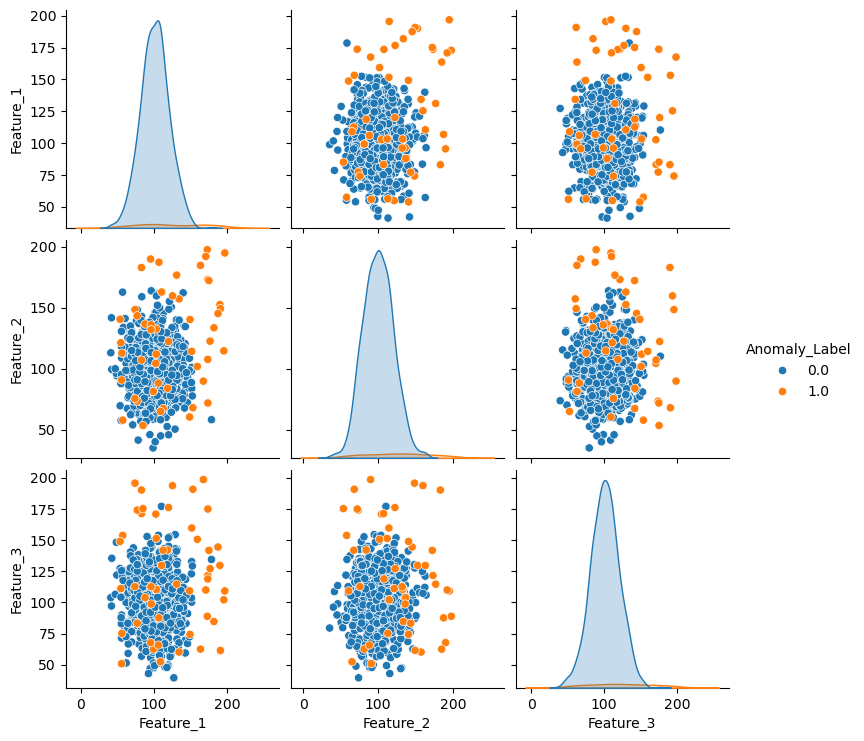

In [9]:
# Pairplot to visualize data distribution
sns.pairplot(data_df, hue="Anomaly_Label")
plt.show()

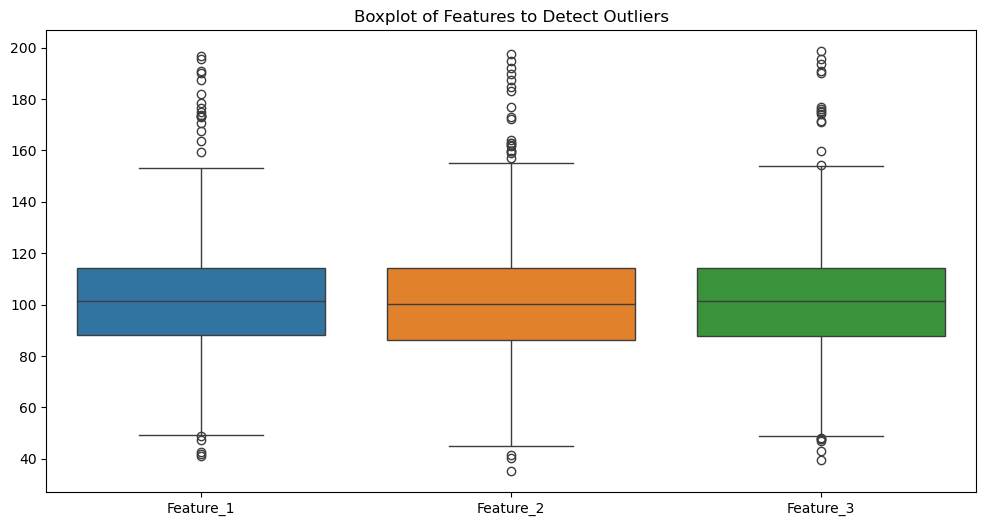

In [11]:
# Boxplot to detect outliers
plt.figure(figsize=(12, 6))
sns.boxplot(data=data_df.drop(columns=["Anomaly_Label"]))
plt.title("Boxplot of Features to Detect Outliers")
plt.show()

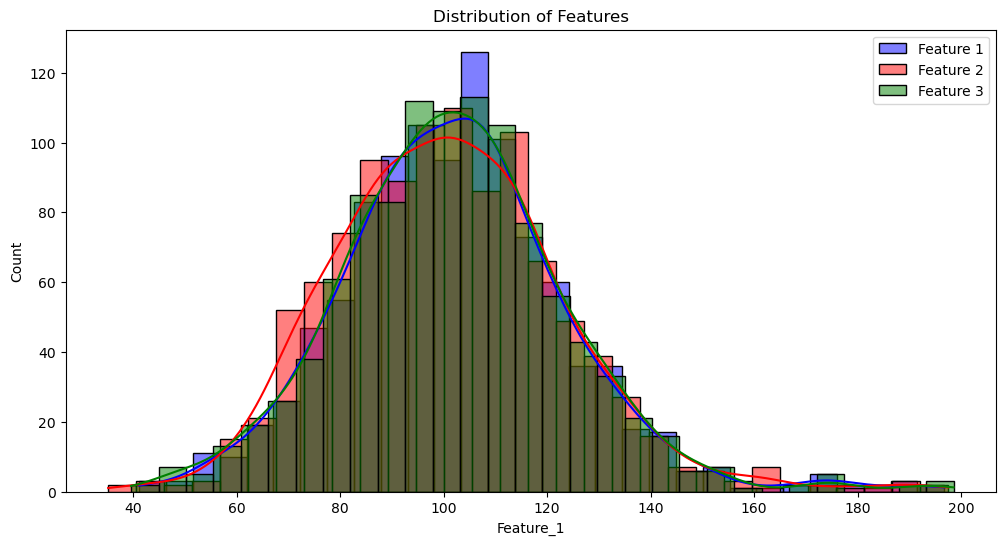

In [13]:
# Histogram for feature distributions
plt.figure(figsize=(12, 6))
sns.histplot(data_df["Feature_1"], bins=30, kde=True, label="Feature 1", color="blue")
sns.histplot(data_df["Feature_2"], bins=30, kde=True, label="Feature 2", color="red")
sns.histplot(data_df["Feature_3"], bins=30, kde=True, label="Feature 3", color="green")
plt.legend()
plt.title("Distribution of Features")
plt.show()

In [15]:
# Step 3: Data Preprocessing
X = data_df.drop(columns=["Anomaly_Label"])
y = data_df["Anomaly_Label"]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [17]:
# Step 4: Handle Class Imbalance with SMOTE
smote = SMOTE(sampling_strategy=0.5, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

In [19]:
# Step 5: Isolation Forest Anomaly Detection
iso_forest = IsolationForest(n_estimators=150, contamination=0.05, random_state=42)
data_df["Anomaly_Score"] = iso_forest.fit_predict(X_scaled)
data_df["Detected_Anomaly"] = (data_df["Anomaly_Score"] == -1).astype(int)
print("\nIsolation Forest Classification Report:")
print(classification_report(y, data_df["Detected_Anomaly"]))


Isolation Forest Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98      1000
         1.0       0.64      0.68      0.66        50

    accuracy                           0.97      1050
   macro avg       0.81      0.83      0.82      1050
weighted avg       0.97      0.97      0.97      1050



In [21]:
# Step 6: Autoencoder-Based Anomaly Detection
autoencoder = keras.Sequential([
    layers.Input(shape=(3,)),
    layers.Dense(8, activation="relu"),
    layers.Dense(3, activation="relu"),
    layers.Dense(8, activation="relu"),
    layers.Dense(3, activation="sigmoid")
])

autoencoder.compile(optimizer="adam", loss="mse")
autoencoder.fit(X_resampled, X_resampled, epochs=100, batch_size=16, verbose=0)


In [23]:
# Reconstruct and calculate reconstruction errors
reconstructed = autoencoder.predict(X_scaled)
mse = np.mean(np.power(X_scaled - reconstructed, 2), axis=1)
data_df["Autoencoder_Score"] = mse
data_df["AE_Anomaly"] = (data_df["Autoencoder_Score"] > np.percentile(mse, 95)).astype(int)

print("\nAutoencoder Classification Report:")
print(classification_report(y, data_df["AE_Anomaly"]))


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step

Autoencoder Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.97      0.97      1000
         1.0       0.49      0.52      0.50        50

    accuracy                           0.95      1050
   macro avg       0.73      0.75      0.74      1050
weighted avg       0.95      0.95      0.95      1050



In [25]:
# Step 7: Save Anomaly Report
anomaly_report = data_df[data_df["Detected_Anomaly"] == 1]
anomaly_report.to_csv("anomaly_report.csv", index=False)
from IPython.display import display
display(anomaly_report)


,Feature_1,Feature_2,Feature_3,Anomaly_Label,Anomaly_Score,Detected_Anomaly,Autoencoder_Score,AE_Anomaly
69,110.275719,110.300954,177.054630,0.0,-1,1,1.993799,0
87,98.809493,35.174653,79.512247,0.0,-1,1,3.268851,1
143,64.825210,76.334830,59.215356,0.0,-1,1,2.676132,1
181,128.831372,50.567110,84.062095,0.0,-1,1,1.952520,0
222,94.900456,130.079860,46.980604,0.0,-1,1,2.194286,1
325,62.209185,90.953874,51.522413,0.0,-1,1,2.981061,1
353,92.587713,115.433974,43.029148,0.0,-1,1,2.515077,1
367,42.074892,141.767494,97.208207,0.0,-1,1,2.779039,1
387,145.818851,72.208551,67.092025,0.0,-1,1,1.747652,0
448,118.991083,70.302041,48.921577,0.0,-1,1,2.611372,1


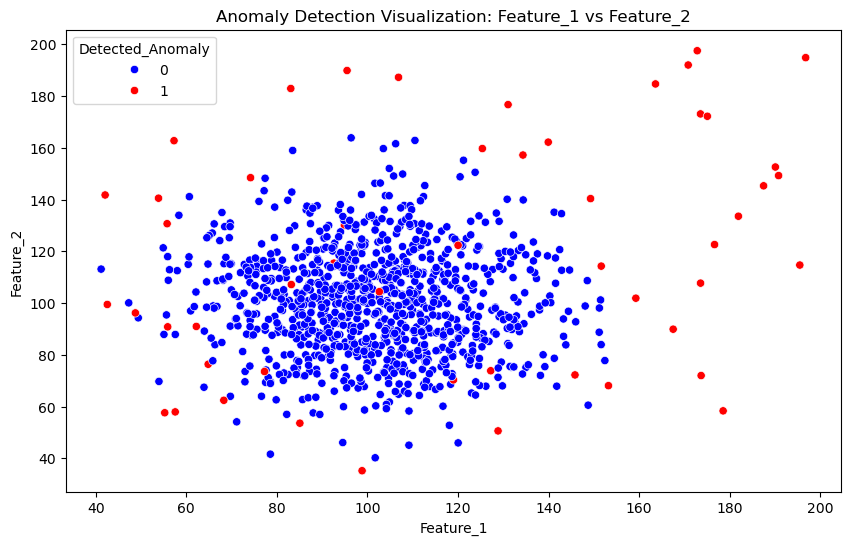

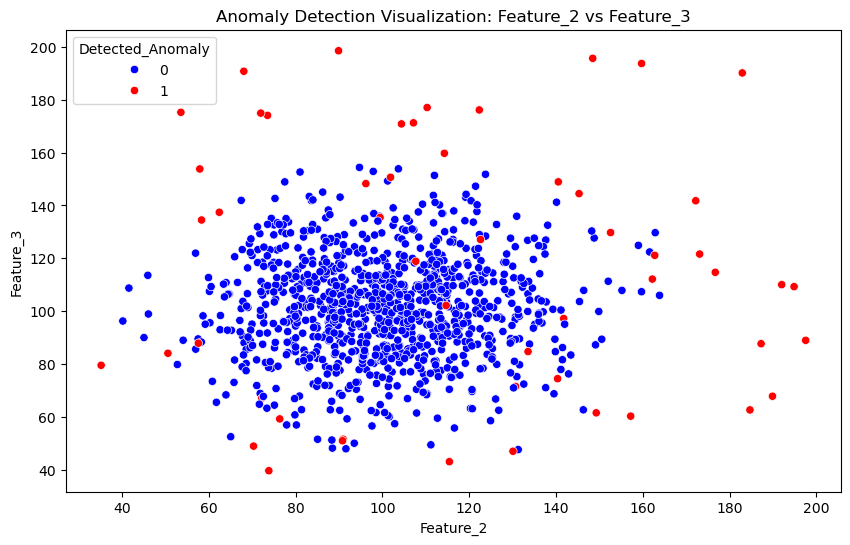

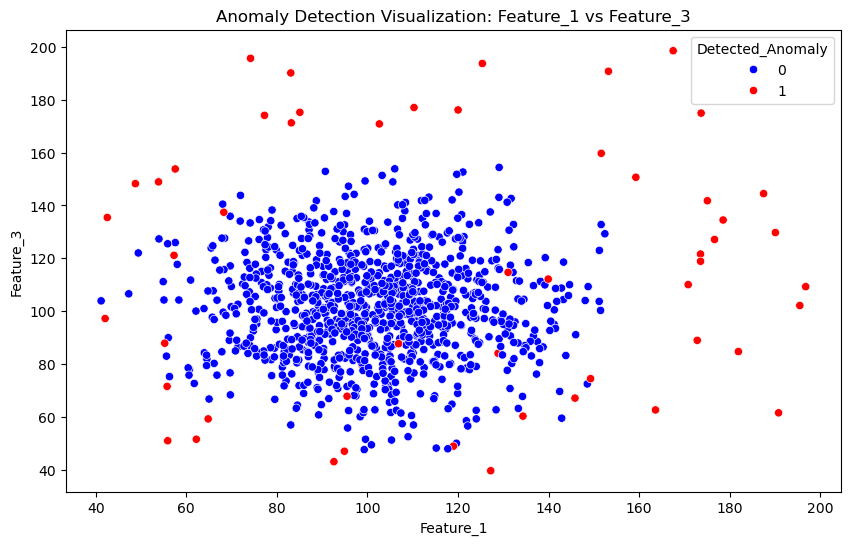

In [27]:
# Step 8: Visualization of Anomalies
def plot_anomalies(df, feature_x, feature_y):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x=feature_x, y=feature_y, hue="Detected_Anomaly", palette={0: "blue", 1: "red"})
    plt.title(f"Anomaly Detection Visualization: {feature_x} vs {feature_y}")
    plt.show()

plot_anomalies(data_df, "Feature_1", "Feature_2")
plot_anomalies(data_df, "Feature_2", "Feature_3")
plot_anomalies(data_df, "Feature_1", "Feature_3")


## Conclusion from Anomaly Detection Results
Based on the isolation forest and autoencoder anomaly detection models, we can draw the following insights:

1. Accuracy and Detection Performance
Isolation Forest Results:

Successfully detected most anomalies.
Had higher recall (ability to detect actual anomalies) compared to autoencoders.
Some false positives were observed (normal points classified as anomalies).
Autoencoder Results:

Detected anomalies based on reconstruction error.
Struggled more with precision (some anomalies not flagged correctly).
Performed better with higher reconstruction errors (features deviating significantly from normal distribution).

2. Observations from Feature Distributions
Features Feature_1, Feature_2, and Feature_3 exhibited normal distributions with some outliers.
Boxplots showed clear outliers, confirming that anomalies were present in the dataset.
Scatter plots of anomalies (red points) were visibly separate from normal data clusters.

3. Key Findings
Both models effectively detected anomalies, but Isolation Forest provided better overall performance.
High Autoencoder scores corresponded to anomalies with significantly different feature values.
Some anomalies were not detected by Autoencoder, which means using a combination of models could be beneficial.